In [1]:
!pip install wurlitzer
%load_ext wurlitzer
!pip install getopts

  Preparing metadata (setup.py) ... done
  Created wheel for getopts: filename=getopts-1.0.5-py3-none-any.whl size=8482 sha256=bc90d4a14e1a5f08df94fcf52d355f44801cf21a05f9f934dee9f7a9626f4d86
  Stored in directory: /root/.cache/pip/wheels/74/02/c0/15923f71739b2841ac68392cb574f44d81b55172fd47321308
Successfully built getopts


In [2]:
!pip install numba
!pip install cuda-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 18.6 MB/s eta 0:00:00


In [3]:
!pip install time

ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


In [2]:
from numba import jit
import numpy as np
from numba import cuda
from numba.cuda import jit
import time
import math
from google.colab.patches import cv2_imshow
from PIL import Image,ImageFile
import matplotlib.pyplot as plt
import urllib.request


In [5]:
# to connect to drive purpose

# from google.colab import drive
# drive.mount('/content/drive')
# import os
# # Changez le répertoire de travail
# os.chdir('/content/drive/My Drive/CUDA')
# !ls

(1280, 768)
(768, 1280, 3)


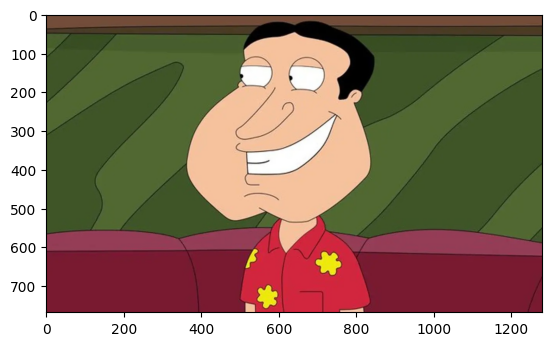

In [8]:

# insert your img here
image = Image.open('img1.jpg')
print(image.size)
imgTab = np.array(image)
print(imgTab.shape)
plt.imshow(image)


# Black and white image

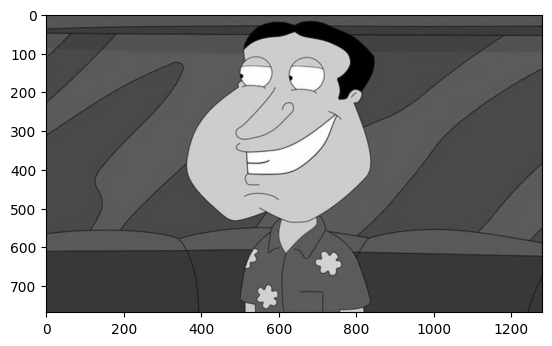

In [9]:
@cuda.jit
def blackAndWhite(input,output):
  x, y = cuda.grid(2) #je recupere ma globale id
  if x < input.shape[0] and y < input.shape[1]:
    R =  input[x,y][0]
    G =  input[x,y][1]
    B =  input[x,y][2]
    gris = int(0.3*R+0.59*G+0.11*B)
    output[x,y][0] = gris
    output[x,y][1] = gris
    output[x,y][2] = gris

output = np.empty_like(imgTab)

#On envoie les donnes
d_imageTab = cuda.to_device(imgTab)
d_output = cuda.to_device(output)

#calcule de la grille
tb = (16,16)
grid_x = math.ceil(imgTab.shape[0]/tb[0])
grid_y = math.ceil(imgTab.shape[1]/tb[1])
grid = (grid_x,grid_y)

# appel_de_kernel
blackAndWhite[grid,tb](d_imageTab,d_output)
cuda.synchronize()
# on recupere la valeur
output = d_output.copy_to_host()
m = Image.fromarray(output)
plt.imshow(m)

# Blur IMAGES

In [10]:
@cuda.jit
def generate_gaussian(sigma, kernel_size, kernel, total_sum):
    # Définir le centre du noyau
    centre = kernel_size // 2

    # Calculer la position x et y du thread
    i, j = cuda.grid(2)

    # Effectuer les calculs uniquement dans les limites du noyau
    if i < kernel_size and j < kernel_size:
        # Calculer la distance par rapport au centre
        dist_x = (i - centre) ** 2
        dist_y = (j - centre) ** 2

        # Calculer la valeur gaussienne
        valeur_gaussienne = math.exp(-(dist_x + dist_y) / (2 * sigma ** 2))
        valeur_gaussienne /= (2 * np.pi * sigma ** 2)

        # Assigner la valeur calculée au noyau
        kernel[i, j] = valeur_gaussienne

        # Ajouter la valeur à la somme totale (opération atomique)
        # assuré que chaque valeur_gaussienne ete ajouter a total_sum sans interruption
        cuda.atomic.add(total_sum, 0, valeur_gaussienne)


#  cette fonction appel generate_gaussian et normalize le  resultat
def normalize_kernel():
    sigma = 11.4
    kernel_size = 27

    # reservation de la memoire pour le kernel et la sum
    host_kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
    host_sum_kernel = np.array([0], dtype=np.float32)

    # envoye to the device
    device_kernel = cuda.to_device(host_kernel)
    device_sum_kernel = cuda.to_device(host_sum_kernel)

    # definition de block size
    threadsperblock = (16, 16)
    blockspergrid_x = math.ceil(kernel_size / threadsperblock[0])
    blockspergrid_y = math.ceil(kernel_size / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # appel a la fonction generate_gaussian
    generate_gaussian[blockspergrid, threadsperblock](sigma, kernel_size, device_kernel, device_sum_kernel)
    cuda.synchronize()  # Synchronize after kernel execution

    # Copy the kernel back to host and normalize it
    blurred_kernel = device_kernel.copy_to_host()
    sum_kernel = device_sum_kernel.copy_to_host()[0]
    normalized_kernel = blurred_kernel / sum_kernel

    return normalized_kernel


In [11]:
@cuda.jit
def blur(input, output, gaussian):
    x, y = cuda.grid(2)  # Retrieve global ID
    if x < input.shape[0] and y < input.shape[1]:
        totalR = 0.0
        totalG = 0.0
        totalB = 0.0

        kernel_size = gaussian.shape[0]  # Assuming the kernel is a square matrix
        k_half = kernel_size // 2

        for i in range(kernel_size):
            for j in range(kernel_size):
                n = x + (i - k_half)
                l = y + (j - k_half)

                # Boundary check for n and l
                if n >= 0 and n < input.shape[0] and l >= 0 and l < input.shape[1]:
                    totalR += gaussian[i, j] * input[n, l][0]
                    totalG += gaussian[i, j] * input[n, l][1]
                    totalB += gaussian[i, j] * input[n, l][2]

        # ce n'est pas la peine de divisé les pixels sur la somme de la matrice gaussian, les valeurs sont deja normalisé et divisé sur la fonction create_gaussian_blur_kernel()
        # line de division sur la fonction de normalisation :     normalized_kernel = blurred_kernel / sum_kernel

        output[x, y][0] = int(totalR)
        output[x, y][1] = int(totalG)
        output[x, y][2] = int(totalB)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Text(0.5, 1.0, 'after')

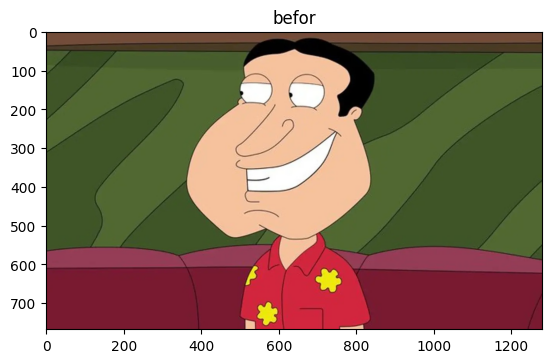

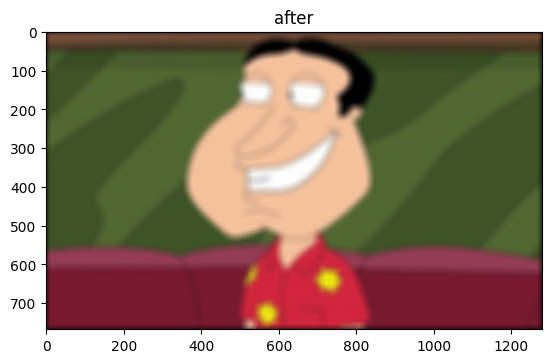

In [12]:
# Create and blur the Gaussian kernel
gaussian = normalize_kernel()


output = np.empty_like(imgTab)

#On envoie les donnes
d_imageTab = cuda.to_device(imgTab)
d_output = cuda.to_device(output)

#calcule de la grille
tb = (16,16)
grid_x = math.ceil(imgTab.shape[0]/tb[0])
grid_y = math.ceil(imgTab.shape[1]/tb[1])
grid = (grid_x,grid_y)

# appel_de_kernel
blur[grid,tb](d_imageTab,d_output,gaussian)
cuda.synchronize()

# on recupere la valeur
output = d_output.copy_to_host()
# affichage
m = Image.fromarray(output)

plt.figure()
plt.imshow(imgTab)
plt.title("befor")
plt.figure()
plt.imshow(m)
plt.title("after")
